## Dataset 1: predicting income based on census data

In [1]:
import time
total_start_time = time.time()

### Starting off: preparing the data

We need to prepare the data before we can do the training on it. Let's read it in and fix missing data.

##### dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels as sm
import seaborn as sns
import sklearn as skl

##### read in data, separate X and y

In [3]:
adult = pd.read_csv('dataset1.txt',sep=',',header=None)
adult.columns = [['age','workclass','fnlwgt','education',
                 'education-num','marital-status',
                 'occupation','relationship','race',
                 'sex','capital-gain','capital-loss',
                 'hours-per-week','native-country',
                 'Income']]

##### split adult into X and y

In [4]:
X = adult[['age','workclass','fnlwgt','education',
                 'education-num','marital-status',
                 'occupation','relationship','race',
                 'sex','capital-gain','capital-loss',
                 'hours-per-week','native-country']]
y = pd.get_dummies(adult['Income'])[' >50K']
y.columns = [' >50K']
df = pd.concat([X,y],axis=1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


##### check for and replace '?' data points with mode of the feature

In [5]:
print 'y value counts:\n',y.value_counts()
Xq = []
for col in X:
    if ' ?' in X[col].value_counts().index:
        Xq.append(col) 
print Xq

y value counts:
0    24720
1     7841
Name:  >50K, dtype: int64
['workclass', 'occupation', 'native-country']


There are no ? entries in y, but we can see that there are ? data points in workclass, occupation, and native-country. Let's check the mode of each variable.

In [6]:
for col in Xq:
    print col,X[col].mode()

workclass 0     Private
dtype: object
occupation 0     Prof-specialty
dtype: object
native-country 0     United-States
dtype: object


So the modes are workclass: Private occupation: Prof-specialty; native-country: United-States. Let's check though to make sure that these are more than just minority modes before replacing them.

Axes(0.125,0.125;0.775x0.755)


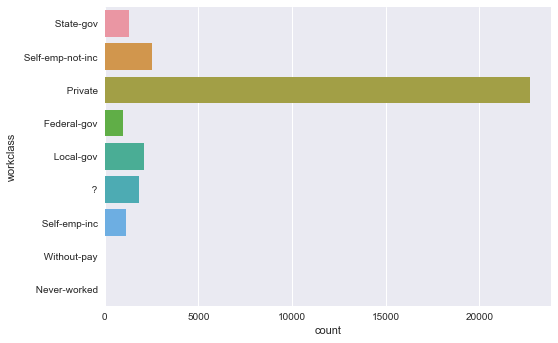

In [7]:
print sns.countplot(y='workclass',data=X)

Looks like it would be safe to replace ? with Private for workclass for native-country.

Axes(0.125,0.125;0.775x0.755)


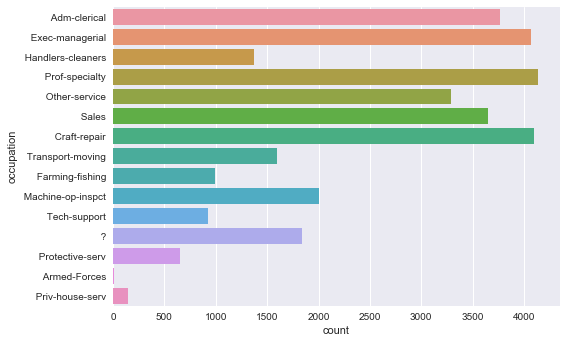

In [8]:
print sns.countplot(y='occupation',data=X)

Doesn't look like it would be safe to replace the ? entries with the mode as the mode is only barely the most frequent category. We may have to simply leave it in for now.

Axes(0.125,0.125;0.775x0.755)


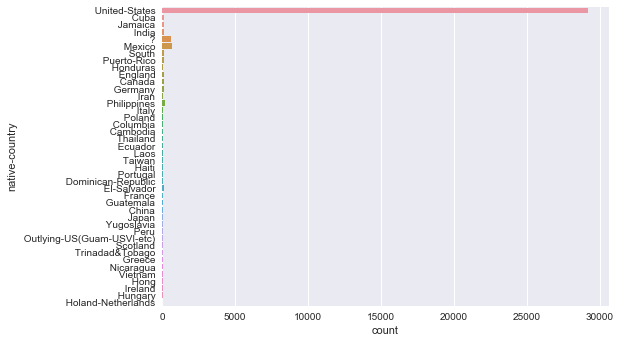

In [9]:
print sns.countplot(y='native-country',data=X,orient='v')

Looks like it's safe to assume the US as the native country for ? entries.

So we can see that the modes of native-country and workclass represent accurate replacements for their respective '?' entries, while the occupation mode does not. Let's go ahead and replace the entries for workclass and native-country; we'll remove the ? entry dummy from the logistic regression at the time of creating dummies. 

In [10]:
# get all observations with ? occupation
occ_q = adult[adult['occupation']==' ?']

print occ_q['Income'].value_counts()
print occ_q['native-country'].value_counts()
print occ_q['sex'].value_counts()

 <=50K    1652
 >50K      191
Name: Income, dtype: int64
 United-States         1666
 Mexico                  33
 ?                       27
 Canada                  14
 Philippines             10
 South                    9
 Taiwan                   9
 Germany                  9
 China                    7
 El-Salvador              6
 Italy                    5
 Puerto-Rico              5
 England                  4
 Poland                   4
 Cuba                     3
 Columbia                 3
 Dominican-Republic       3
 Portugal                 3
 Vietnam                  3
 Japan                    3
 Haiti                    2
 France                   2
 Trinadad&Tobago          1
 Honduras                 1
 Peru                     1
 Guatemala                1
 Jamaica                  1
 Nicaragua                1
 Hong                     1
 Ecuador                  1
 Laos                     1
 Thailand                 1
 Scotland                 1
 Cambodia          

In [11]:
# replace '?' data points with mode of each column
df['workclass'] = df['workclass'].str.replace('?','Private')
print df['workclass'].value_counts()
# native-country   
df['native-country'] = df['native-country'].str.replace('?','United-States')
print df['native-country'].value_counts()

 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
 United-States                 29753
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan       

We can see from the value counts check that the ? entries are gone and the US and Private counts have increased. Let's check on some other dataset features before we start modeling.

##### correlations

We'll create dummies for each categorical variable and make a visual representation of all the correlations between variables in the dataset.

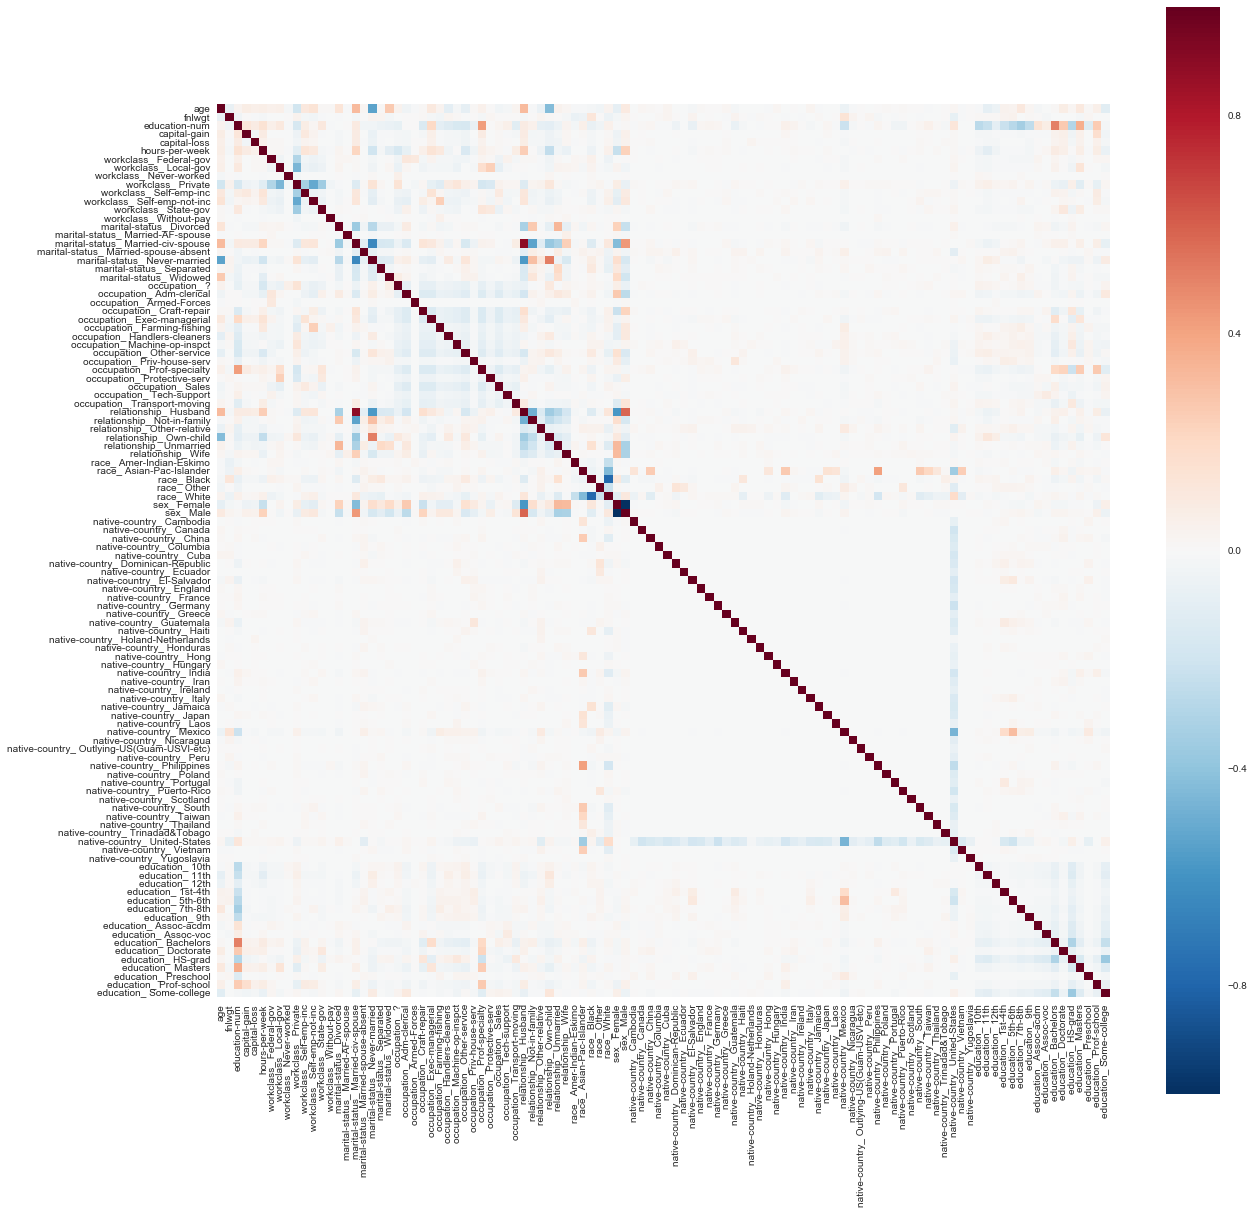

In [12]:
data = df
X_continuous = data[['age','fnlwgt','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
X_dummies = pd.get_dummies(data[['workclass','marital-status','occupation',
                                      'relationship','race','sex','native-country',
                                      'education']]) 
X = pd.concat([X_continuous,X_dummies],axis=1)
# create correlations plot
plt.subplots(figsize=(20,20))
sns.heatmap(X.corr(),square=True)

If we expand the image, we can see that there are some correlation problems in the dummified dataset that occur mostly between options of the dummies. For example, being male correlates highly with being not female, and vice versa. We'll have to ignore these correlations for now as they are implicit in the use of dummies.

### basic regression of all things in dataset, without fixing '?' values or removing any variables

Let's try a basic logistic regression to see how the variables impact the outcome and how we can improve the others.

##### create dummies from categorical features, split, and scale data 

In [13]:
# prepare simple logistic regression with categorical variables dummified
data = df
X_continuous = data[['age','fnlwgt','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
X_dummies = pd.get_dummies(data[['workclass','marital-status','occupation',
                                      'relationship','race','sex','native-country',
                                      'education']]) 
X = pd.concat([X_continuous,X_dummies],axis=1)
# recall: y variable is in ' >50K' column of df
y = data[' >50K']
# split data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=1234)
#scale data
# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")),columns=X_train.columns)
X_test = scaler.transform(X_test.astype("float64"))

##### create, fit, train, test, evaluate logistic regression model

In [14]:
# create
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
# fit
logmodel.fit(X_train,y_train)
# test
pred1 = logmodel.predict(X_test)
#evaluate
from sklearn.metrics import confusion_matrix
print confusion_matrix(y_test,pred1)
print 'classification success rate:',(float(confusion_matrix(y_test,pred1)[0][0]) / float(y_test.shape[0]))
print 'misclassification error rate:',1 - (float(confusion_matrix(y_test,pred1)[0][0]) / float(y_test.shape[0]))
logreg1 = {'misclassification error rate1':1 - (float(confusion_matrix(y_test,pred1)[0][0]) / float(y_test.shape[0]))}

[[11432   946]
 [ 1524  2379]]
classification success rate: 0.702168171488
misclassification error rate: 0.297831828512


So we were able to successfully predict whether income was above or below 50K for 70% of the observations. Let's look at how each variable impacted the predictions.

##### checking variable contribution with coefficient bar plot

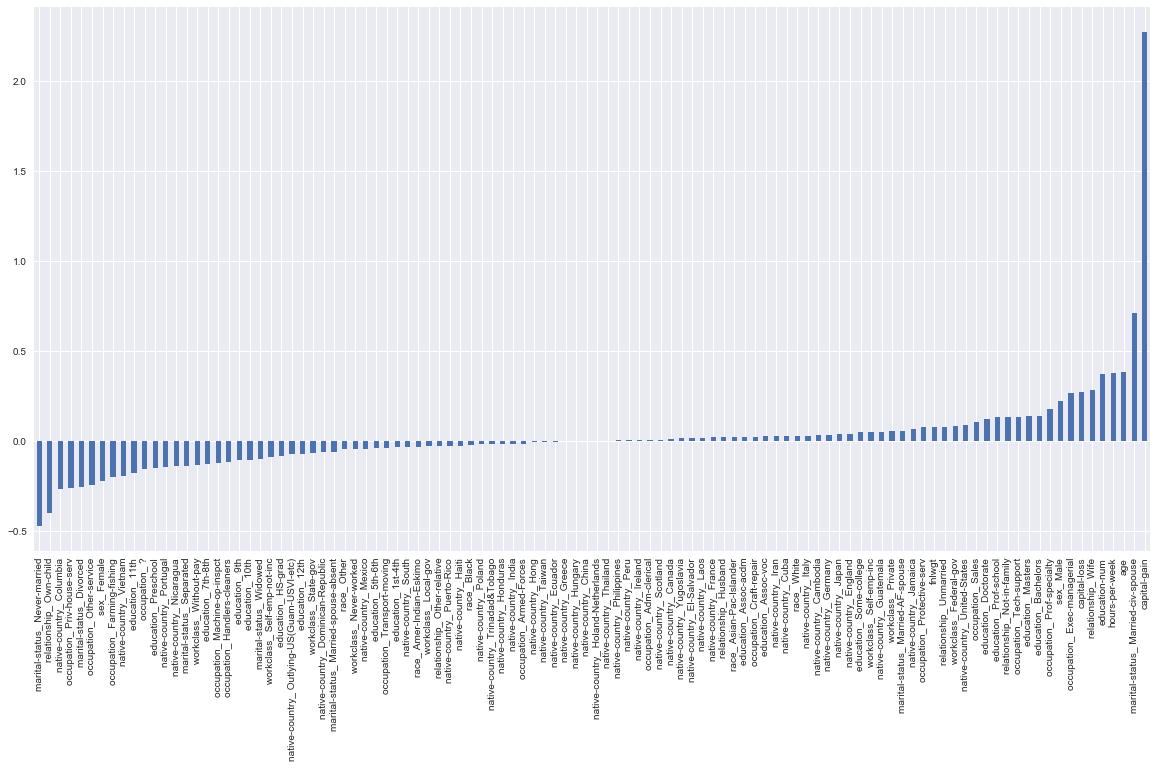

In [15]:
# plot coefficients
coefs = pd.Series(logmodel.coef_[0],index=X_train.columns)
coefs = coefs.sort_values()
plt.subplots(figsize=(20,10))
coefs.plot(kind='bar')

We can see with close inspection that the top positive features are being married, male, and executive, or highly educated. However, the education dummy is pretty redundant considering that the education-num variable does the same thing but on a continuous basis. Let's remove that variable next time. Also, hours per week somehow has a highly negative influence, which seems wrong, as does age. Let's try this regression again with some different variables.

We'll remove the education categorical variable first.

[[11431   947]
 [ 1522  2381]]
0.2978932498


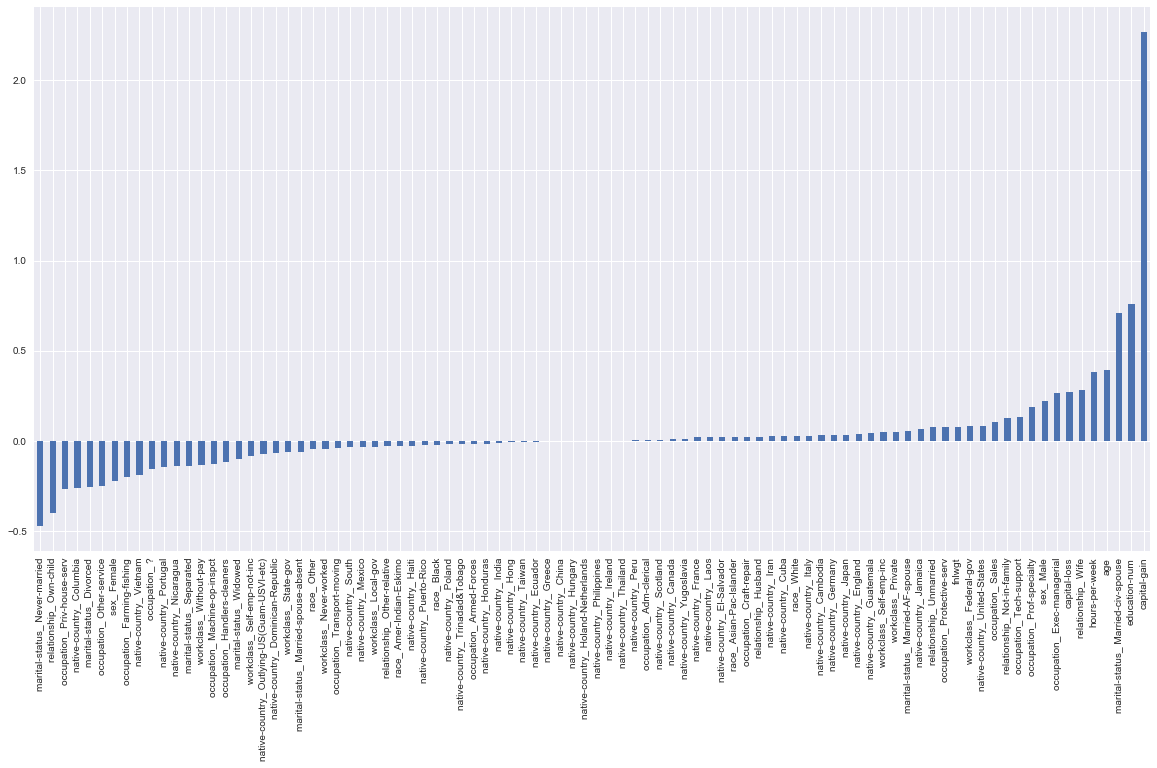

In [16]:
### WHOLE THING AGAIN

#create function for iterations of regression
def LogReg(regnum,X_continuous,X_dummies,y,plot):
    #create dummies
    X = pd.concat([X_continuous,X_dummies],axis=1)
    # split data
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=1234)
    # scale data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")),columns=X_train.columns)
    X_test = scaler.transform(X_test.astype("float64"))
    # create
    from sklearn.linear_model import LogisticRegression
    logmodel = LogisticRegression()
    # fit
    logmodel.fit(X_train,y_train)
    # test
    pred = logmodel.predict(X_test)
    #evaluate
    from sklearn.metrics import confusion_matrix
    print confusion_matrix(y_test,pred)
    classification_success_rate = (float(confusion_matrix(y_test,pred)[0][0]) / float(y_test.shape[0]))
    misclassification_error_rate = 1 - classification_success_rate
    print misclassification_error_rate
    # plot coefficients
    if plot == 'y': 
        coefs = pd.Series(logmodel.coef_[0],index=X_train.columns)
        coefs = coefs.sort_values()
        plt.subplots(figsize=(20,10))
        coefs.plot(kind='bar')
    evaluate = {'misclassification error rate%d:'%regnum:misclassification_error_rate}
    return evaluate
# prepare simple logistic regression with categorical variables dummified
data = df
Xcont = data[['age','fnlwgt','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['workclass','marital-status','occupation',
                                      'relationship','race','sex','native-country'
                                      ]]) 
# recall: y variable is in ' >50K' column of df
y = df[' >50K']
# call function to complete regression
logreg2 = LogReg(2,Xcont,Xdum,y,'y')

In [17]:
print logreg1,'\n',logreg2

{'misclassification error rate1': 0.29783182851176215} 
{'misclassification error rate2:': 0.2978932498003808}


We can see that simply removing the education vector fixed the coefficients of some of the variables that we'd expect to be positive rather than negative, but the misclassification rate actually went down a tiny a bit instead of making it far more accurate. We'll leave the education variable out for now.

The fnlwgt variable is a guess of how many people in a country the data represent, but that doesn't seem very relevant. Let's try the model without it.

[[11430   948]
 [ 1533  2370]]
0.297954671089


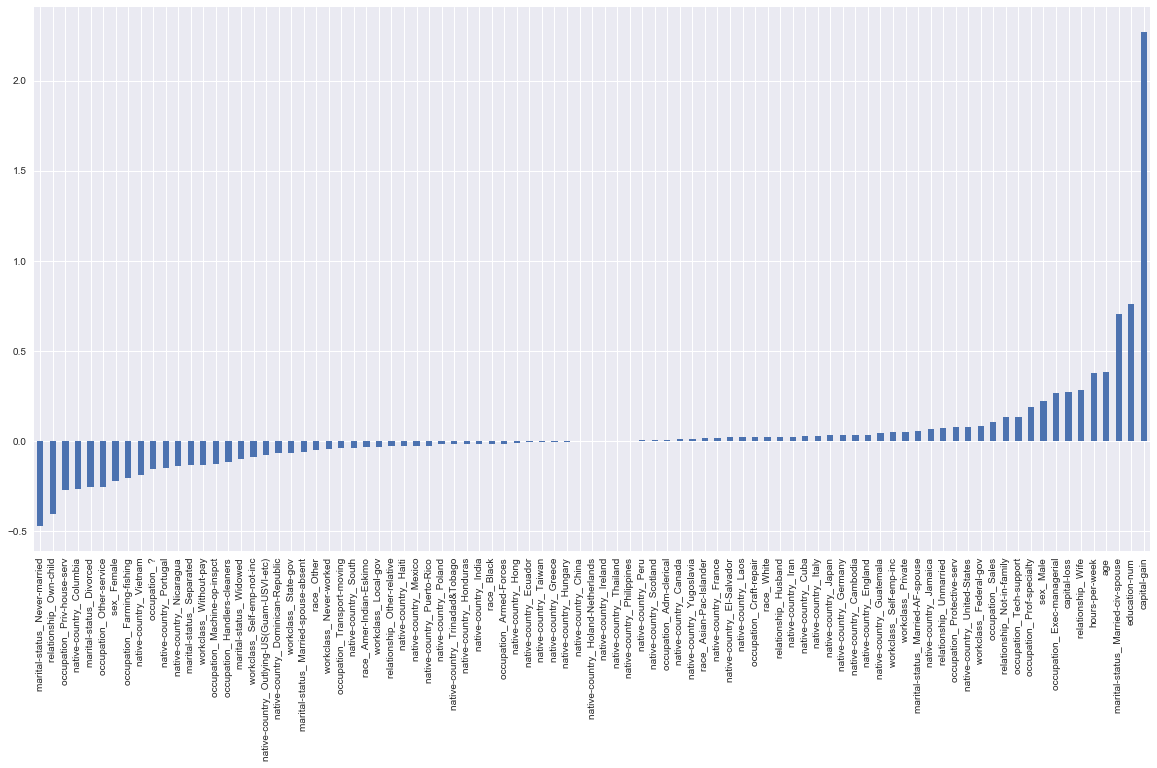

In [18]:
### WHOLE THING AGAIN
# prepare simple logistic regression with categorical variables dummified
data = df
X_continuous = data[['age','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
X_dummies = pd.get_dummies(data[['workclass','marital-status','occupation',
                                 'relationship','race','sex',
                                 'native-country']]) 
logreg3 = LogReg(3,X_continuous,X_dummies,y,'y')

In [19]:
print logreg1,'\n',logreg2,'\n',logreg3

{'misclassification error rate1': 0.29783182851176215} 
{'misclassification error rate2:': 0.2978932498003808} 
{'misclassification error rate3:': 0.2979546710889994}


This made the model worse. We'll leave it in. This time, let's check to see whether the observations with occupation '?' are affecting the accuracy of the model by removing the dummy for 'occupation_ ?'.

In [20]:
# prepare simple logistic regression with categorical variables dummified
data = df
Xcont = data[['age','fnlwgt','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['workclass','marital-status','occupation',
                                      'relationship','race','sex','native-country'
                                      ]]) 
# recall: y variable is in ' >50K' column of data
y = data[' >50K']
# call function to complete regression
logreg4 = LogReg(4, Xcont,Xdum.drop('occupation_ ?',axis=1),y,'n')

[[11432   946]
 [ 1522  2381]]
0.297831828512


In [21]:
print logreg1,'\n',logreg2,'\n',logreg3,'\n',logreg4

{'misclassification error rate1': 0.29783182851176215} 
{'misclassification error rate2:': 0.2978932498003808} 
{'misclassification error rate3:': 0.2979546710889994} 
{'misclassification error rate4:': 0.29783182851176215}


This has given us the smallest error rate yet, but nothing we're doing seems to be increasing accuracy in a major way. Try grouping.

## Linear Discriminant Analysis

In [22]:
def LDAModel(num,X_continuous,X_dummies,yvar):
    import time
    start_time = time.time()
    Xdf = pd.concat([X_continuous,X_dummies],axis=1)
    # split data
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(Xdf,yvar,test_size=0.5,random_state=1234)
    # scale data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")),columns=X_train.columns)
    X_test = scaler.transform(X_test.astype("float64"))
    # create
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
    lda = LDA()
    #fit
    lda.fit(X_train,y_train)
    #test
    pred = lda.predict(X_test)
    #evaluate
    from sklearn.metrics import confusion_matrix
    print confusion_matrix(y_test,pred)
    classification_success_rate = (float(confusion_matrix(y_test,pred)[0][0]) / float(y_test.shape[0]))
    misclassification_error_rate = 1 - classification_success_rate
    print classification_success_rate
    print misclassification_error_rate
    evaluate = {'misclassification error rate%d:'%num:misclassification_error_rate}
    print '----- run time:',time.time() - start_time,'------'
    return evaluate

In [23]:
data = df
Xcont = data[['age','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['workclass','marital-status','occupation',
                                      'relationship','race','sex','native-country']]) 
y = data[' >50K']

lda1 = LDAModel(1,Xcont,Xdum,y)
print lda1

[[11330  1048]
 [ 1634  2269]]
0.695903200049
0.304096799951
----- run time: 1.00999999046 ------
{'misclassification error rate1:': 0.3040967999508629}


C:\Users\russd\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [24]:
data = df
Xcont = data[['age','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['marital-status','sex']]) 
y = data[' >50K']

lda2 = LDAModel(2,Xcont,Xdum,y)
print lda2

[[11418   960]
 [ 1849  2054]]
0.701308273448
0.298691726552
----- run time: 0.31299996376 ------
{'misclassification error rate2:': 0.29869172655242304}


In [25]:
data = df
Xcont = data[['age','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['sex']]) 
y = data[' >50K']

lda3 = LDAModel(3,Xcont,Xdum,y)
print lda3

[[11725   653]
 [ 2414  1489]]
0.720164609053
0.279835390947
----- run time: 0.225000143051 ------
{'misclassification error rate3:': 0.279835390946502}


In [26]:
data = df
Xcont = data[['education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['sex']]) 
y = data[' >50K']

lda4 = LDAModel(4,Xcont,Xdum,y)
print lda4

[[11871   507]
 [ 2673  1230]]
0.729132117192
0.270867882808
----- run time: 0.213999986649 ------
{'misclassification error rate4:': 0.2708678828081813}


In [27]:
data = df
Xcont = data[['education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['workclass']]) 
y = data[' >50K']

lda5 = LDAModel(5,Xcont,Xdum,y)
print lda5

[[11867   511]
 [ 2797  1106]]
0.728886432037
0.271113567963
----- run time: 0.292999982834 ------
{'misclassification error rate5:': 0.27111356796265584}


As we took out more and more dummies the error rate kept decreasing. Let's try removing the dummies altogether and then testing the variables.

In [28]:
def LDAModel_nodummy(num,X_continuous,yvar):
    import time
    start_time = time.time()
    Xdf = X_continuous
    # split data
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(Xdf,yvar,test_size=0.5,random_state=1234)
    # scale data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")),columns=X_train.columns)
    X_test = scaler.transform(X_test.astype("float64"))
    # create
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
    lda = LDA()
    #fit
    lda.fit(X_train,y_train)
    #test
    pred = lda.predict(X_test)
    #evaluate
    from sklearn.metrics import confusion_matrix
    print confusion_matrix(y_test,pred)
    classification_success_rate = (float(confusion_matrix(y_test,pred)[0][0]) / float(y_test.shape[0]))
    misclassification_error_rate = 1 - classification_success_rate
    print classification_success_rate
    print misclassification_error_rate
    evaluate = {'misclassification error rate%d:'%num:misclassification_error_rate}
    print '----- run time:',time.time() - start_time,'------'
    return evaluate

In [29]:
data = df
Xcont = data[['education-num','capital-gain',
                     'capital-loss','hours-per-week']] 
y = data[' >50K']

lda6 = LDAModel_nodummy(6,Xcont,y)
print lda6

[[11928   450]
 [ 2884  1019]]
0.732633130643
0.267366869357
----- run time: 0.177999973297 ------
{'misclassification error rate6:': 0.2673668693569191}


So we got our lowest error rate yet simply by excluding all the dummy variables. Let's try starting with no variables and adding them one by one.

In [30]:
data = df
Xcont = data[['capital-gain']] 
y = data[' >50K']

lda7 = LDAModel_nodummy(7,Xcont,y)
print lda7

[[12375     3]
 [ 3778   125]]
0.760088446656
0.239911553344
----- run time: 0.174000024796 ------
{'misclassification error rate7:': 0.23991155334438918}


In [31]:
data = df
Xcont = data[['capital-gain']]
y = data[' >50K']
lda8 = LDAModel_nodummy(8,Xcont,y)

[[12375     3]
 [ 3778   125]]
0.760088446656
0.239911553344
----- run time: 0.171000003815 ------


So simply by removing every variable except the most highly correlated - capital gain - we got our lowest error rate yet.

### ---> lowest error rate with LDA: 23.99%

## Quadratic Discriminant Analysis

In [32]:
# function for QDA with both continuous and dummies
def QDAModel(num,X_continuous,X_dummies,yvar):
    import time
    start_time = time.time()
    Xdf = pd.concat([X_continuous,X_dummies],axis=1)
    # split data
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(Xdf,yvar,test_size=0.5,random_state=1234)
    # scale data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")),columns=X_train.columns)
    X_test = scaler.transform(X_test.astype("float64"))
    # create
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
    qda = QDA()
    #fit
    qda.fit(X_train,y_train)
    #test
    pred = qda.predict(X_test)
    #evaluate
    from sklearn.metrics import confusion_matrix
    print confusion_matrix(y_test,pred)
    classification_success_rate = (float(confusion_matrix(y_test,pred)[0][0]) / float(y_test.shape[0]))
    misclassification_error_rate = 1 - classification_success_rate
    print classification_success_rate
    evaluate = {'misclassification error rate%d:'%num:misclassification_error_rate}
    print '----- run time:',time.time() - start_time,'seconds ------'
    print evaluate
    return evaluate
# QD with no dummies
def QDAModel_nodummy(num,X_continuous,yvar):
    import time
    start_time = time.time()
    Xdf = X_continuous
    # split data
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(Xdf,yvar,test_size=0.5,random_state=1234)
    # scale data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")),columns=X_train.columns)
    X_test = scaler.transform(X_test.astype("float64"))
    # create
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
    qda = QDA()
    #fit
    qda.fit(X_train,y_train)
    #test
    pred = qda.predict(X_test)
    #evaluate
    from sklearn.metrics import confusion_matrix
    print confusion_matrix(y_test,pred)
    classification_success_rate = (float(confusion_matrix(y_test,pred)[0][0]) / float(y_test.shape[0]))
    misclassification_error_rate = 1 - classification_success_rate
    print classification_success_rate
    evaluate = {'misclassification error rate%d:'%num:misclassification_error_rate}
    print '----- run time:',time.time() - start_time,'seconds ------'
    print evaluate
    return evaluate

##### Using the QD model:

With both continuous and dummy variables:

In [33]:
data = df
Xcont = data[['age','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['workclass','marital-status','occupation',
                                      'relationship','race','sex','native-country']]) 
y = data[' >50K']

qda1 = QDAModel(1,Xcont,Xdum,y)

C:\Users\russd\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[[4810 7568]
 [ 356 3547]]
0.295436398256
----- run time: 0.736000061035 seconds ------
{'misclassification error rate1:': 0.7045636017443646}


In [34]:
data = df
Xcont = data[['education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['workclass']]) 
y = data[' >50K']

qda1 = QDAModel(2,Xcont,Xdum,y)

[[12378     0]
 [ 3903     0]]
0.760272710521
----- run time: 0.192000150681 seconds ------
{'misclassification error rate2:': 0.23972728947853328}


In [35]:
data = df
Xcont = data[['capital-gain',
                     ]]
Xdum = pd.get_dummies(data[['sex','workclass']]) 
y = data[' >50K']

qda1 = QDAModel(2,Xcont,Xdum,y)

[[12378     0]
 [ 3903     0]]
0.760272710521
----- run time: 0.180999994278 seconds ------
{'misclassification error rate2:': 0.23972728947853328}


QDA with no dummies:

In [36]:
data = df
Xcont = data[['capital-gain','hours-per-week']]
y = data[' >50K']

qda1 = QDAModel_nodummy(2,Xcont,y)

[[12085   293]
 [ 3052   851]]
0.742276272956
----- run time: 0.155999898911 seconds ------
{'misclassification error rate2:': 0.2577237270437934}


### ---> lowest error rate with QDA: 23.97%

## K Nearest Neighbors model

We've already created much of the data we need for KNN modeling, so we can go ahead and jump right in.

In [37]:
def KNNModel(KNNnum,X_continuous,X_dummies,yvar,neighbors):
    import time
    start_time = time.time()
    Xdf = pd.concat([X_continuous,X_dummies],axis=1)
    # split data
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(Xdf,yvar,test_size=0.5,random_state=1234)
    # scale data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")),columns=X_train.columns)
    X_test = scaler.transform(X_test.astype("float64"))
    # create
    from sklearn.neighbors import KNeighborsClassifier as KNN
    #create
    knn = KNN(n_neighbors=neighbors)
    #fit
    knn.fit(X_train,y_train)
    #test
    pred = knn.predict(X_test)
    #evaluate
    from sklearn.metrics import confusion_matrix
    print confusion_matrix(y_test,pred)
    classification_success_rate = (float(confusion_matrix(y_test,pred)[0][0]) / float(y_test.shape[0]))
    misclassification_error_rate = 1 - classification_success_rate
    print classification_success_rate
    print misclassification_error_rate
    evaluate = {'misclassification error rate%d:'%KNNnum:misclassification_error_rate}
    print '----- run time:',time.time() - start_time,'------'
    return evaluate   

In [38]:
# create and test KNN model
data = df
Xcont = data[['age','fnlwgt','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['workclass','marital-status','occupation',
                            'relationship','education','race','sex',
                            'native-country']])
y = data[' >50K']
X = pd.concat([X_continuous,X_dummies],axis=1)
# split data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=1234)

In [39]:
# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")),columns=X_train.columns)
X_test = scaler.transform(X_test.astype("float64"))
# create
from sklearn.neighbors import KNeighborsClassifier as KNN


In [40]:
#create
knn = KNN()
#fit
knn.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [41]:
#test
pred = knn.predict(X_test)


In [42]:
#evaluate
from sklearn.metrics import confusion_matrix
print confusion_matrix(y_test,pred)
classification_success_rate = (float(confusion_matrix(y_test,pred)[0][0]) / float(y_test.shape[0]))
misclassification_error_rate = 1 - classification_success_rate
print classification_success_rate
print misclassification_error_rate
knn1 = {'misclassification error rate%d:'%1:misclassification_error_rate}
print knn1

[[11173  1205]
 [ 1658  2245]]
0.686260057736
0.313739942264
{'misclassification error rate1:': 0.3137399422639887}


This error rate is higher than the best logistic regression model; this may be because we have so many dummy variables. Let's try the KNN with all the continuous variables fewer dummies: marital status, occupation,relationship, race, sex, and country.

In [43]:
Xcont = data[['age','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['marital-status','occupation',
                            'relationship','race','sex',
                            'native-country']])
y = data[' >50K']
knn2 = KNNModel(2,Xcont,Xdum,y,2)
print knn2

[[11692   686]
 [ 2302  1601]]
0.718137706529
0.281862293471
----- run time: 134.049000025 ------
{'misclassification error rate2:': 0.28186229347091707}


This error rate is...exactly the same, so these variables seem to have not done much. Let's try excluding all dummies except marital status and sex.

In [44]:
Xcont = data[['age','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
Xdum = pd.get_dummies(data[['marital-status','sex']])
y = data[' >50K']
knn3 = KNNModel(3,Xcont,Xdum,y,3)
print knn2

[[10995  1383]
 [ 1647  2256]]
0.675327068362
0.324672931638
----- run time: 26.1949999332 ------
{'misclassification error rate2:': 0.28186229347091707}


This model has a higher error rate, and took almost 3 minutes to run for some reason.

As in the linear discriminant analysis, let's try doing k nearest neigbors with only a few variables to reduce noise.

In [45]:
Xcont = data[['capital-gain']]
Xdum = pd.get_dummies(data[['marital-status']])
y = data[' >50K']
knn4 = KNNModel(4,Xcont,Xdum,y,3)
print knn4

[[8374 4004]
 [ 452 3451]]
0.514341870892
0.485658129108
----- run time: 19.7209999561 ------
{'misclassification error rate4:': 0.4856581291075487}


Simplicity seems to have increased the error rate.

### ---> lowest error rate with KNN: 31.37%

## Naive Bayes

In [46]:
def NBModel(num,X_continuous,X_dummies,yvar):
    import time
    start_time = time.time()
    Xdf = pd.concat([X_continuous,X_dummies],axis=1)
    # split data
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(Xdf,yvar,test_size=0.5,random_state=1234)
    # scale data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")),columns=X_train.columns)
    X_test = scaler.transform(X_test.astype("float64"))
    # create
    from sklearn.naive_bayes import GaussianNB as GNB
    gnb = GNB()
    gnb.fit(X_train,y_train)
    pred = gnb.predict(X_test)
    #evaluate
    from sklearn.metrics import confusion_matrix
    print confusion_matrix(y_test,pred)
    classification_success_rate = (float(confusion_matrix(y_test,pred)[0][0]) / float(y_test.shape[0]))
    misclassification_error_rate = 1 - classification_success_rate
    print classification_success_rate
    evaluate = {'misclassification error rate%d:'%num:misclassification_error_rate}
    print '----- run time:',time.time() - start_time,'seconds ------'
    print evaluate
    return evaluate
#NBModel no dummies
def NBModel_nodummy(num,X_continuous,yvar):
    import time
    start_time = time.time()
    
    Xdf = X_continuous
    # split data
    from sklearn.model_selection import train_test_split
    X_train,X_test,y_train,y_test = train_test_split(Xdf,yvar,test_size=0.5,random_state=1234)
    # scale data
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")),columns=X_train.columns)
    X_test = scaler.transform(X_test.astype("float64"))
    # create
    from sklearn.naive_bayes import GaussianNB as GNB
    gnb = GNB()
    gnb.fit(X_train,y_train)
    pred = gnb.predict(X_test)
    #evaluate
    from sklearn.metrics import confusion_matrix
    print confusion_matrix(y_test,pred)
    classification_success_rate = (float(confusion_matrix(y_test,pred)[0][0]) / float(y_test.shape[0]))
    misclassification_error_rate = 1 - classification_success_rate
    print classification_success_rate
    evaluate = {'misclassification error rate%d:'%num:misclassification_error_rate}
    print '----- run time:',time.time() - start_time,'seconds ------'
    print evaluate
    return evaluate

In [47]:
data = df
Xcont = data[['age','education-num','capital-gain',
                     'capital-loss','hours-per-week']]
y = data[' >50K']
nb1 = NBModel_nodummy(1,Xcont,y)


[[11793   585]
 [ 2701  1202]]
0.72434125668
----- run time: 0.200000047684 seconds ------
{'misclassification error rate1:': 0.27565874332043483}


In [48]:
data = df
Xcont = data[['capital-gain','age']]
y = data[' >50K']
nb1 = NBModel_nodummy(1,Xcont,y)


[[12084   294]
 [ 3055   848]]
0.742214851668
----- run time: 0.199000120163 seconds ------
{'misclassification error rate1:': 0.25778514833241206}


In [49]:
Xcont = data[['capital-gain']]
Xdum = pd.get_dummies(data[['sex','race']])
y = data[' >50K']
nb2 = NBModel(2,Xcont,Xdum,y)

[[12042   336]
 [ 3063   840]]
0.739635157546
----- run time: 0.208999872208 seconds ------
{'misclassification error rate2:': 0.26036484245439473}


In [1]:

data = df
Xcont = data[['capital-gain','age']]
Xdum = pd.get_dummies(data[['sex']])
y = data[' >50K']
nb1 = NBModel(1,Xcont,Xdum,y)


NameError: name 'df' is not defined

### ---> lowest error rate with Naive Bayes: 25.74%

In [51]:
print 'total system time:',time.time()-total_start_time

total system time: 409.586000204
